In [1]:
# =============================================================================
# Title   : Fuzzy Logic Portfolio — Health & Biomedicine (3 Examples)
# Course  : Models and Methods of Intelligent Systems
# Topic   : Fuzzy Decision Support for Triage, Pain, and Dosage Suggestion
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# Date    : 2026-01-27
#
# Contents
# --------
# 1) Clinical Triage (heart rate, fever -> severity)
# 2) Pain Assessment (self-report, function limitation -> pain)
# 3) Dosage Suggestion (risk, symptoms -> dose)
# =============================================================================

# =========================
# Install & Imports
# =========================
!pip -q install scikit-fuzzy ipywidgets
import numpy as np, matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass
print("Setup complete.")

# =========================
# Helper Utilities
# =========================
def plot_mfs(variable, title_suffix=""):
    plt.figure()
    for term_name, term_obj in variable.terms.items():
        plt.plot(variable.universe, term_obj.mf, label=term_name)
    plt.title(f"Membership Functions — {variable.label} {title_suffix}".strip())
    plt.xlabel(variable.label); plt.ylabel("Membership degree")
    plt.ylim(-0.05, 1.05); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

def report_system(title, antecedents, consequents, rules):
    print("\n" + "="*80); print(title); print("="*80)
    def _describe(v):
        u = v.universe
        print(f"\nVariable: {v.label}")
        print(f"  Universe: [{float(u.min()):.4f}, {float(u.max()):.4f}] | Points: {len(u)}")
        print("  Fuzzy sets (terms):")
        for t in v.terms.keys(): print(f"    - {t}")
    print("\n--- Antecedents (Inputs) ---")
    for a in antecedents: _describe(a)
    print("\n--- Consequents (Outputs) ---")
    for c in consequents: _describe(c)
    print("\n--- Rule Base ---")
    for i, r in enumerate(rules, 1): print(f"{i:02d}. {str(r)}")

def build_dashboard(system, inputs_spec, output_name, title):
    sim = ctrl.ControlSystemSimulation(system)
    sliders = {name: FloatSlider(value=v0, min=vmin, max=vmax, step=step,
                                 description=name, continuous_update=False)
               for (name, vmin, vmax, step, v0) in inputs_spec}
    display(HTML(f"<h3 style='margin:6px 0'>{title}</h3>"))
    def _run(**kwargs):
        for k, v in kwargs.items(): sim.input[k] = float(v)
        sim.compute()
        y = float(sim.output[output_name])
        print(f"{output_name} (defuzzified) = {y:.6f}")
        return y
    interact(_run, **sliders)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00
Setup complete.



Example 1 — Clinical Triage (hr, fever → severity)

--- Antecedents (Inputs) ---

Variable: hr
  Universe: [40.0000, 160.0000] | Points: 241
  Fuzzy sets (terms):
    - low
    - normal
    - high

Variable: fever
  Universe: [35.0000, 41.0000] | Points: 241
  Fuzzy sets (terms):
    - normal
    - mild
    - high

--- Consequents (Outputs) ---

Variable: severity
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - medium
    - high

--- Rule Base ---
01. IF hr[normal] AND fever[normal] THEN severity[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF hr[high] AND fever[normal] THEN severity[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF hr[normal] AND fever[mild] THEN severity[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF hr[high] AND fever[mild] THEN severity[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
05. IF fever[high] THEN severi

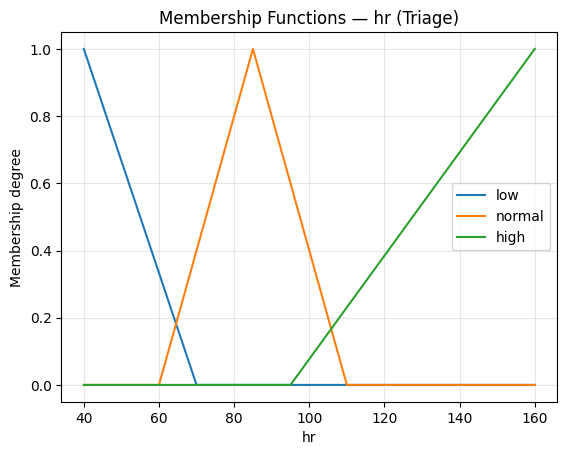

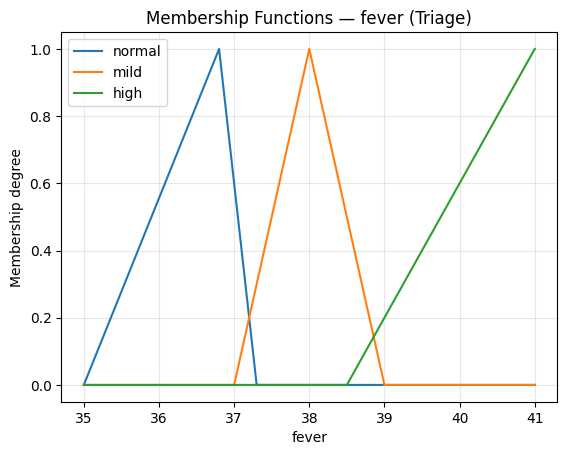

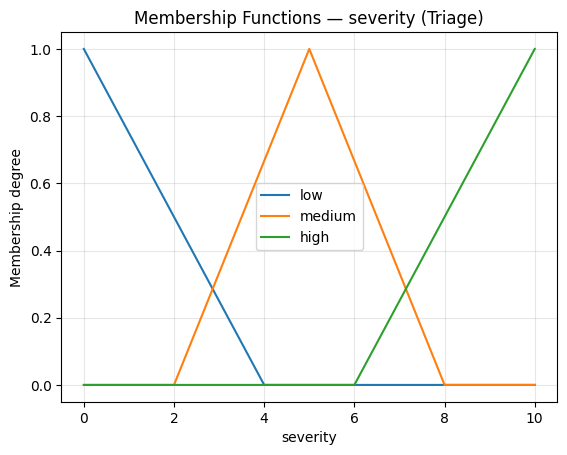

HTML(value="<h3 style='margin:6px 0'>Example 1 — Triage Dashboard</h3>")

interactive(children=(FloatSlider(value=95.0, continuous_update=False, description='hr', max=160.0, min=40.0, …

In [2]:
# Example 1 — Clinical Triage
hr = ctrl.Antecedent(np.linspace(40, 160, 241), 'hr')
fever = ctrl.Antecedent(np.linspace(35, 41, 241), 'fever')
severity = ctrl.Consequent(np.linspace(0, 10, 201), 'severity')

hr['low'] = fuzz.trimf(hr.universe, [40, 40, 70])
hr['normal'] = fuzz.trimf(hr.universe, [60, 85, 110])
hr['high'] = fuzz.trimf(hr.universe, [95, 160, 160])

fever['normal'] = fuzz.trimf(fever.universe, [35, 36.8, 37.3])
fever['mild'] = fuzz.trimf(fever.universe, [37.0, 38.0, 39.0])
fever['high'] = fuzz.trimf(fever.universe, [38.5, 41.0, 41.0])

severity['low'] = fuzz.trimf(severity.universe, [0, 0, 4])
severity['medium'] = fuzz.trimf(severity.universe, [2, 5, 8])
severity['high'] = fuzz.trimf(severity.universe, [6, 10, 10])

rules = [
    ctrl.Rule(hr['normal'] & fever['normal'], severity['low']),
    ctrl.Rule(hr['high'] & fever['normal'], severity['medium']),
    ctrl.Rule(hr['normal'] & fever['mild'], severity['medium']),
    ctrl.Rule(hr['high'] & fever['mild'], severity['high']),
    ctrl.Rule(fever['high'], severity['high']),
]
system = ctrl.ControlSystem(rules)

report_system("Example 1 — Clinical Triage (hr, fever → severity)", [hr, fever], [severity], rules)
plot_mfs(hr, "(Triage)"); plot_mfs(fever, "(Triage)"); plot_mfs(severity, "(Triage)")
build_dashboard(system, [('hr', 40, 160, 1, 95), ('fever', 35, 41, 0.1, 38.2)], 'severity',
                "Example 1 — Triage Dashboard")


Example 2 — Pain Assessment (self_report, function_limit → pain)

--- Antecedents (Inputs) ---

Variable: self_report
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

Variable: function_limit
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Consequents (Outputs) ---

Variable: pain
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF self_report[low] AND function_limit[low] THEN pain[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF self_report[mid] OR function_limit[mid] THEN pain[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF self_report[high] OR function_limit[high] THEN pain[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax


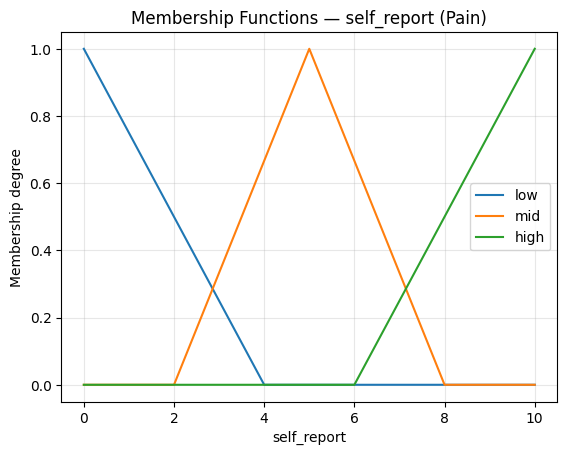

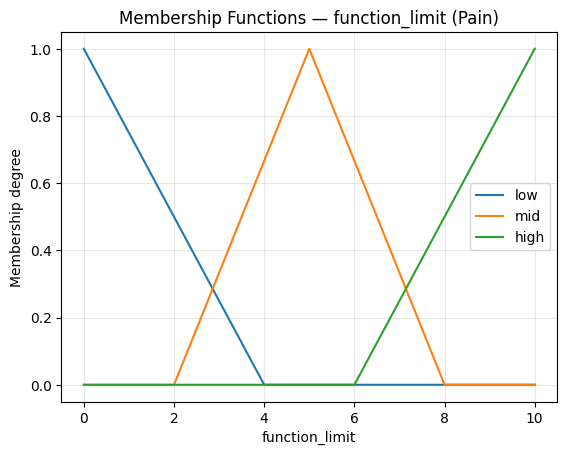

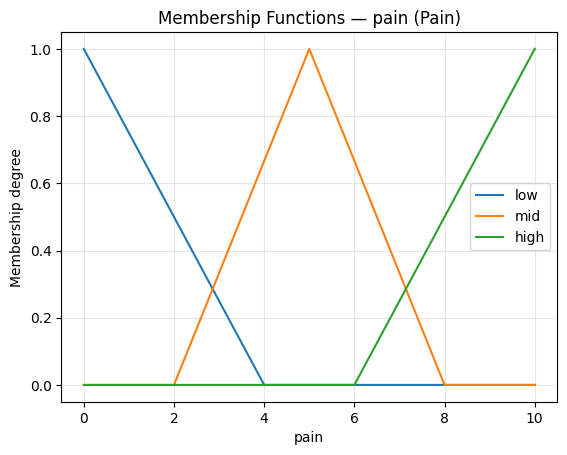

HTML(value="<h3 style='margin:6px 0'>Example 2 — Pain Dashboard</h3>")

interactive(children=(FloatSlider(value=6.0, continuous_update=False, description='self_report', max=10.0), Fl…

In [3]:
# Example 2 — Pain Assessment
self_report = ctrl.Antecedent(np.linspace(0, 10, 201), 'self_report')
function_limit = ctrl.Antecedent(np.linspace(0, 10, 201), 'function_limit')
pain = ctrl.Consequent(np.linspace(0, 10, 201), 'pain')

for v in [self_report, function_limit]:
    v['low'] = fuzz.trimf(v.universe, [0, 0, 4])
    v['mid'] = fuzz.trimf(v.universe, [2, 5, 8])
    v['high'] = fuzz.trimf(v.universe, [6, 10, 10])

pain['low'] = fuzz.trimf(pain.universe, [0, 0, 4])
pain['mid'] = fuzz.trimf(pain.universe, [2, 5, 8])
pain['high'] = fuzz.trimf(pain.universe, [6, 10, 10])

rules = [
    ctrl.Rule(self_report['low'] & function_limit['low'], pain['low']),
    ctrl.Rule(self_report['mid'] | function_limit['mid'], pain['mid']),
    ctrl.Rule(self_report['high'] | function_limit['high'], pain['high']),
]
system = ctrl.ControlSystem(rules)

report_system("Example 2 — Pain Assessment (self_report, function_limit → pain)",
              [self_report, function_limit], [pain], rules)
plot_mfs(self_report, "(Pain)"); plot_mfs(function_limit, "(Pain)"); plot_mfs(pain, "(Pain)")
build_dashboard(system, [('self_report', 0, 10, 0.1, 6.0), ('function_limit', 0, 10, 0.1, 4.0)],
                'pain', "Example 2 — Pain Dashboard")


Example 3 — Dosage Suggestion (risk, symptoms → dose)

--- Antecedents (Inputs) ---

Variable: risk
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

Variable: symptoms
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: dose
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF risk[high] AND symptoms[low] THEN dose[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF risk[high] AND symptoms[high] THEN dose[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF risk[low] AND symptoms[low] THEN dose[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF risk[low] AND symptoms[high] THEN dose[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax


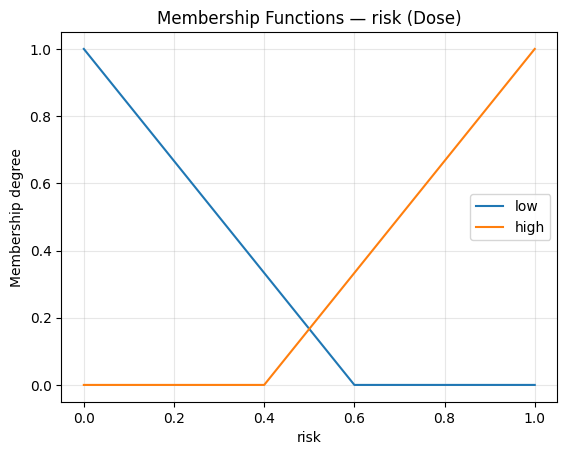

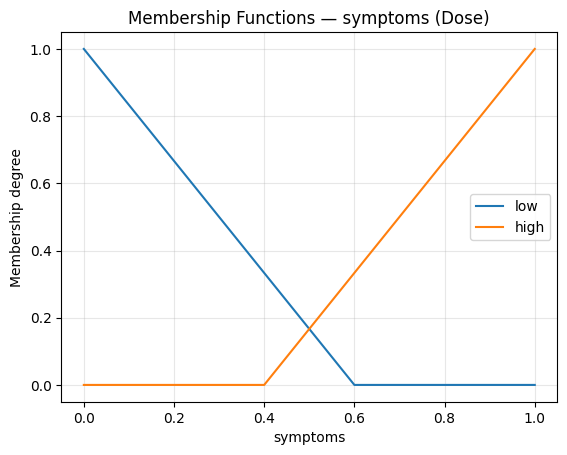

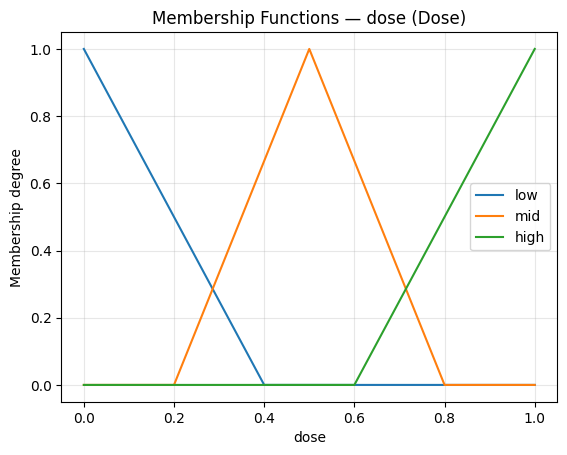

HTML(value="<h3 style='margin:6px 0'>Example 3 — Dosage Dashboard</h3>")

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='risk', max=1.0, step=0.01),…

In [4]:
# Example 3 — Dosage Suggestion
risk = ctrl.Antecedent(np.linspace(0, 1, 201), 'risk')
symptoms = ctrl.Antecedent(np.linspace(0, 1, 201), 'symptoms')
dose = ctrl.Consequent(np.linspace(0, 1, 201), 'dose')

risk['low'] = fuzz.trimf(risk.universe, [0, 0, 0.6])
risk['high'] = fuzz.trimf(risk.universe, [0.4, 1, 1])

symptoms['low'] = fuzz.trimf(symptoms.universe, [0, 0, 0.6])
symptoms['high'] = fuzz.trimf(symptoms.universe, [0.4, 1, 1])

dose['low'] = fuzz.trimf(dose.universe, [0, 0, 0.4])
dose['mid'] = fuzz.trimf(dose.universe, [0.2, 0.5, 0.8])
dose['high'] = fuzz.trimf(dose.universe, [0.6, 1, 1])

rules = [
    ctrl.Rule(risk['high'] & symptoms['low'], dose['low']),
    ctrl.Rule(risk['high'] & symptoms['high'], dose['mid']),
    ctrl.Rule(risk['low'] & symptoms['low'], dose['low']),
    ctrl.Rule(risk['low'] & symptoms['high'], dose['high']),
]
system = ctrl.ControlSystem(rules)

report_system("Example 3 — Dosage Suggestion (risk, symptoms → dose)", [risk, symptoms], [dose], rules)
plot_mfs(risk, "(Dose)"); plot_mfs(symptoms, "(Dose)"); plot_mfs(dose, "(Dose)")
build_dashboard(system, [('risk', 0, 1, 0.01, 0.3), ('symptoms', 0, 1, 0.01, 0.7)],
                'dose', "Example 3 — Dosage Dashboard")